Authors: Lydia Jeong, Gabriel Vesco, Yousra Abdelmoula, Ali Chibani, Nisrine Dandache <br>
Data Warriors <br>
UN Hackathon <br>
November 8-11, 2022 <br>

Sentiment Analysis is a branch of Natural Language Processing (NLP) that allows us to determine algorithmically whether a statement or document is “positive” or “negative”. Sentiment analysis is a technology of increasing importance in the modern society as it allows individuals and organizations to detect trends in public opinion by analyzing social media content. Keeping abreast of socio-political developments is especially important during periods of natural disasters and climate change action, such that countries can make the appropriate changes to support their climate-related policies and help achieve the Sustainable Development Goals.

We will develop a model that aims to help inform a given country of their current public opinion regarding their respective economical and ecological activity and sentiments associated with it, using tweets regarding climate change. This model will help guide us towards measuring the impact of Climate Change on society as part of monitoring the SDG13 by answering the question: What can public opinion on Twitter tell us about the ecological and economical effects of climate change?

Bridging the NLP with empirical approach ( correlation between CO2 and GDP emissions) to retrieve insightful recommendations about green investment decisions and policy implications.

In [2]:
!pip install nltk

In [3]:
!pip install wordcloud

In [4]:
!pip install xgboost

In [5]:
# Import all required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
import html
import string
import matplotlib.pyplot as plt
import nltk
import io
from google.colab import files
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from html.parser import HTMLParser
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.svm import SVC, LinearSVC, NuSVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from numpy import array
from scipy.sparse import csr_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


The datasets we will be working with are open-source from Kaggle (found here: https://www.kaggle.com/datasets/saurabhshahane/twitter-sentiment-dataset and https://www.kaggle.com/datasets/thedevastator/social-media-sentiment-and-climate-change), and includes information on the sentiment of the posts, as well the time at which the tweet was posted. This dataset has tweets from 2017 to 2019. Though unfortunately there is no country of origin for each tweet, we tentatively  assumed that a majority of these tweets come from developed countries that speak English, such as United States, Canada, and England. Moroever, in a more developped phase of this project, we can specify data by country of origin.

Question: What can public opinion on Twitter tell us about the ecological and economical effects of climate change?

We will go off the assumption that if we see more positive sentiments --> the effects of climate change are less severe
Vice versa, if we see more more negative sentiments --> the effects of climate change are more critical

For this model, we come up with two classification categories to measure climate change: Ecological and Economical.
This way, we can help steer the country towards which aspect of their infrastructure they should focus on improving.

Future iterations of this model could easily incorporate additional categories (ex. technological, agricultural, industrial, etc.) related to climate change, with their own respective key words.

Next, we will predict the sentiment of the climate change data. We apply Bag of Words (BOW) and term frequency–inverse document frequency (TF-IDF) to the general topic twitter dataset, and run various machine learning models to compare the accuracy of sentiment prediction. We select the model with the highest accuracy and apply the model to the climate change dataset, in order to predict the sentiment of climate change related data.

We will also predict the popularity of the tweet of the climate change data.

In [6]:
ecological_words = ['co2', 'carbon', 'emissions', 'disaster', 'weather', 'flood', 'storm',
                    'drought', 'sea level', 'energy', 'arctic', 'heat', 'heat wave', 'climate change',
                    'climate action', 'climate', 'global', 'warming', 'science', 'planet',
                    'weather', 'carbon', 'coal', 'water', 'environmental', 'environment',
                    'fossil', 'arctic', 'oil', 'wildfire', 'fuel', 'sea', 'ice', 'air', 'hot',
                    'solar', 'pollution', 'cold', 'temperature', 'protect', 'greenhouse',
                    'afforestation', 'ocean', 'forest', 'extinction', 'species', 'scientist',
                    'agriculture', 'manufacture', 'renewable']

economical_words = ['cop', 'gdp', 'policy', 'jobs', 'law', 'trump', 'president', 'energy', 'news', 'government', 'policy', 'health',
                    'tax', 'work', 'public', 'administration', 'bill', 'money', 'economy',
                    'movement', 'debate', 'capitalism', 'fighting', 'humanity', 'political',
                    'minister', 'conference', 'politics', 'economic']

overlap_words = ['co2', 'fuel', 'coal', 'fossil', 'gas', 'natural gas', 'petrol']

# Load datasets

2 datasets:
- twitter_df contains tweets on general topic
- climate_df contains tweets on climate change

In [7]:
#for the twitter data
uploaded = files.upload()

Saving Twitter_Data.csv to Twitter_Data.csv


In [8]:
twitter_df = pd.read_csv(io.BytesIO(uploaded['Twitter_Data.csv']))

In [9]:
#for the climate data
uploaded2 = files.upload()

Saving nltk_split.csv to nltk_split.csv


In [10]:
climate_df = pd.read_csv(io.BytesIO(uploaded2['nltk_split.csv']))

In [10]:
twitter_df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [11]:
climate_df.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,id,text,favorite_count,retweet_count,created_at,coordinates,score,neg,neu,pos,compound,created_at_date,Unnamed: 15,Unnamed: 16
0,0,0,0,1.030000e+18,Gotta love the facts. https://t.co/bZ2G8AZuo9,0,0,2018-08-13 10:40:21+00:00,NaN,"{'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'comp...",0.000,0.488,0.512,0.6369,8/13/2018,NaN,NaN
1,1,1,1,1.030000e+18,RT @ToolangiForest: A great day of action for ...,0,35,2018-08-13 10:40:10+00:00,NaN,"{'neg': 0.0, 'neu': 0.651, 'pos': 0.349, 'comp...",0.000,0.651,0.349,0.8805,8/13/2018,NaN,NaN
2,2,2,2,1.030000e+18,@jonkudelka Harvey Norman reckons climate chan...,2,0,2018-08-13 10:40:43+00:00,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,8/13/2018,NaN,NaN
3,3,3,3,1.030000e+18,RT @jayrosen_nyu: Why does skepticism about im...,0,52,2018-08-13 10:40:43+00:00,NaN,"{'neg': 0.146, 'neu': 0.62, 'pos': 0.234, 'com...",0.146,0.620,0.234,0.5267,8/13/2018,NaN,NaN
4,4,4,4,1.030000e+18,RT @FranceinIreland: On 5th November we call a...,0,16,2018-08-13 10:41:58+00:00,NaN,"{'neg': 0.095, 'neu': 0.657, 'pos': 0.248, 'co...",0.095,0.657,0.248,0.4939,8/13/2018,NaN,NaN


# Data cleaning

The twitter_df is already cleaned, we just need to drop null values. Only cleaning to do is the climate_df.

In [11]:
# Drop null values
twitter_df.dropna(inplace=True)

In [12]:
twitter_df.category = twitter_df.category.astype(int)
twitter_df.category = twitter_df.category.astype(str)

In [13]:
# Drop irrevalent columns
climate_df.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 15', 'Unnamed: 16'], inplace=True)

In [14]:
# Display first 5 rows
climate_df.head()

,Unnamed: 0.2,id,text,favorite_count,retweet_count,created_at,coordinates,score,neg,neu,pos,compound,created_at_date
0,0,1.030000e+18,Gotta love the facts. https://t.co/bZ2G8AZuo9,0,0,2018-08-13 10:40:21+00:00,NaN,"{'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'comp...",0.000,0.488,0.512,0.6369,8/13/2018
1,1,1.030000e+18,RT @ToolangiForest: A great day of action for ...,0,35,2018-08-13 10:40:10+00:00,NaN,"{'neg': 0.0, 'neu': 0.651, 'pos': 0.349, 'comp...",0.000,0.651,0.349,0.8805,8/13/2018
2,2,1.030000e+18,@jonkudelka Harvey Norman reckons climate chan...,2,0,2018-08-13 10:40:43+00:00,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,8/13/2018
3,3,1.030000e+18,RT @jayrosen_nyu: Why does skepticism about im...,0,52,2018-08-13 10:40:43+00:00,NaN,"{'neg': 0.146, 'neu': 0.62, 'pos': 0.234, 'com...",0.146,0.620,0.234,0.5267,8/13/2018
4,4,1.030000e+18,RT @FranceinIreland: On 5th November we call a...,0,16,2018-08-13 10:41:58+00:00,NaN,"{'neg': 0.095, 'neu': 0.657, 'pos': 0.248, 'co...",0.095,0.657,0.248,0.4939,8/13/2018


Note: "compound" field indicates a combined score for all three sentiments.
- If compound is a positive value, then it is a positive sentiment.
- If a compound is a negative value, then it is a negative sentiment.

We will rename the "compound" field to "sentiment".

In [15]:
# Select relevant columns
twitter_climate_data = climate_df[['text', 'neg', 'neu', 'pos', 'compound', 'created_at_date', 'favorite_count', 'retweet_count']]
# Rename the "compound" column to "sentiment"
twitter_climate_data.rename(columns = {'compound': 'sentiment'}, inplace = True)

<ipython-input-15-1351938fa98c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_climate_data.rename(columns = {'compound': 'sentiment'}, inplace = True)


In [16]:
# Convert positive value as 1 (positive sentiment), zero as 0 (neutral sentiment), negative value as -1 (negative sentiment)
label = []
for row in twitter_climate_data['sentiment']:
    if row > 0:    label.append('1')
    elif row == 0: label.append('0')
    else:          label.append('-1')

In [17]:
twitter_climate_data['sentiment_label'] = label

<ipython-input-17-a83d2fe8e6a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_climate_data['sentiment_label'] = label


In [18]:
twitter_climate_data = twitter_climate_data[['text', 'sentiment', 'sentiment_label', 'retweet_count', 'created_at_date', ]]
twitter_climate_data.head()

,text,sentiment,sentiment_label,retweet_count,created_at_date
0,Gotta love the facts. https://t.co/bZ2G8AZuo9,0.6369,1,0,8/13/2018
1,RT @ToolangiForest: A great day of action for ...,0.8805,1,35,8/13/2018
2,@jonkudelka Harvey Norman reckons climate chan...,0.0000,0,0,8/13/2018
3,RT @jayrosen_nyu: Why does skepticism about im...,0.5267,1,52,8/13/2018
4,RT @FranceinIreland: On 5th November we call a...,0.4939,1,16,8/13/2018


In [19]:
tweet_list = twitter_climate_data.text.tolist()

In [20]:
# Number of tweets related to climate change
len(tweet_list)

163669

In [21]:
# Number of tweets on general topic
len(twitter_df.clean_text)

162969

In [22]:
tweet_list

['Gotta love the facts. https://t.co/bZ2G8AZuo9',
 'RT @ToolangiForest: A great day of action for our message of “Dear Dan”! Toolangi community &amp; friends joined together to respectfully ask @…',
 '@jonkudelka Harvey Norman reckons climate change is bunkum because his mates who own coal companies need people to buy polluting stuff',
 "RT @jayrosen_nyu: Why does skepticism about immigration walk hand in hand with skepticism about the science of climate change? I know we're…",
 'RT @FranceinIreland: On 5th November we call all creative citizens w/ practical solutions to fight against #climatechange to join us for a…',
 "RT @jayrosen_nyu: Why does skepticism about immigration walk hand in hand with skepticism about the science of climate change? I know we're…",
 "You send me crap\nIt's 5 minutes to midnight for a mute https://t.co/FFhYHCitKb",
 "#Alaska's #NorthSlope hit by strongest #quake noted in region\nhttps://t.co/SP6jhzltFK\nYou want to know WHY?\nBC the… https://t.co/ghqxbCVfqP

In [23]:
def clean_tweets(tweet):
    # All URLs are removed
    cleanr = re.compile('(http|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
    tweet = re.sub(cleanr, '', tweet)

    # All html tags attributes are removed using RegEx.
    tweet = re.sub(r'/<[^<]+?>/', ' ', tweet)

    #Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
    #htmlparser = HTMLParser()
    #tweet = htmlparser.unescape(tweet)
    import html
    tweet = html.unescape(tweet)

    # remove Emojis, symbols, pictures, etc.
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
                               "]+", flags = re.UNICODE)
    tweet = regrex_pattern.sub(r'',tweet)

    # All characters in the text are in lowercase.
    tweet = tweet.lower()

    #remove all punctuations
    tweet=tweet.translate(str.maketrans("","",string.punctuation))
    tweet=tweet.translate(str.maketrans("","",string.digits))

    # Remove stop words. First, modify the stop words list by removing the negation words.
    to_remove = ['no', 'nor', 'not', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'isn', "isn't", 'wasn', "wasn't", 'weren', "weren't",
                "won't", 'wouldn', "wouldn't"]
    stop_words = set(stopwords.words('english')).difference(to_remove) # remove the negation words from the stop words list.

    to_add = {'rt', 'h', 'ht','htt','http','https','https:','https://', '…'}
    stop_words = stop_words.union(to_add)  # include other unimport characters in the stop words list.

    word_tokens = word_tokenize(tweet) # tokenize the tweets
    filtered_sentence = [w for w in word_tokens if w not in stop_words] # filter the sentence to remove stop words.

    return filtered_sentence

In [24]:
# clean both generic and elections tweets
cleaned_tweets = []

for tw in tweet_list:
    cleaned_tweets.append(clean_tweets(tw))

In [25]:
# add the cleaned tweets as a new column to the dataset and drop the original text column
twitter_climate_data['cleaned_tweet_tokenized'] = cleaned_tweets

In [26]:
# add a column 'cleaned_tweet' that has the detokenized texts.
detokenize_sent_analysis = []
for tweet in twitter_climate_data['cleaned_tweet_tokenized']:
    detokenize_sent_analysis.append(TreebankWordDetokenizer().detokenize(tweet))
twitter_climate_data['cleaned_tweet'] = detokenize_sent_analysis

In [27]:
twitter_climate_data = twitter_climate_data[['cleaned_tweet', 'cleaned_tweet_tokenized', 'sentiment', 'sentiment_label', 'created_at_date', 'retweet_count']]
twitter_climate_data

,cleaned_tweet,cleaned_tweet_tokenized,sentiment,sentiment_label,created_at_date,retweet_count
0,gotta love facts,"[got, ta, love, facts]",0.6369,1,8/13/2018,0
1,toolangiforest great day action message “ dear...,"[toolangiforest, great, day, action, message, ...",0.8805,1,8/13/2018,35
2,jonkudelka harvey norman reckons climate chang...,"[jonkudelka, harvey, norman, reckons, climate,...",0.0000,0,8/13/2018,0
3,jayrosennyu skepticism immigration walk hand h...,"[jayrosennyu, skepticism, immigration, walk, h...",0.5267,1,8/13/2018,52
4,franceinireland th november call creative citi...,"[franceinireland, th, november, call, creative...",0.4939,1,8/13/2018,16
...,...,...,...,...,...,...
163664,rrn epa cancels talk climate change agency sci...,"[rrn, epa, cancels, talk, climate, change, age...",-0.2263,-1,10/23/2017,0
163665,time epa pulled scientists climate change conf...,"[time, epa, pulled, scientists, climate, chang...",0.0000,0,10/23/2017,78
163666,cathmckenna must take action climatechange,"[cathmckenna, must, take, action, climatechange]",0.0000,0,10/23/2017,21
163667,time epa pulled scientists climate change conf...,"[time, epa, pulled, scientists, climate, chang...",0.0000,0,10/23/2017,125


# Identify sentiment related to ecological and economical words

In [28]:
def determine_sentiment(df):

    # Relevant words in the tweets that identify to both ecological or economical topics
    relevant_words = '.*co2.*|.*fuel.*|.*coal.*|.*fossil.*|.*gas.*|.*natural gas.*|.*petrol.*'

    # Create new columns: ecological, economical, and Others
    df['relevant_words'] = ''
    df['Others'] = ''

    for i in df.index:
        if re.match (relevant_words, df['cleaned_tweet'][i]) :
            if df['sentiment_label'][i] == '1': # if the sentiment is positive, add 'positive'
                df["relevant_words"][i] = 'positive'
            elif df['sentiment_label'][i] == '0': # if the sentiment is neutral
                df["relevant_words"][i] = 'neutral'
            else :
                df["relevant_words"][i] = 'negative' # if the sentiment is negative, add 'negative'relevant_words

In [29]:
# Apply this function to the twitter dataset.
determine_sentiment(twitter_climate_data)

<ipython-input-28-eb08ea913d32>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["relevant_words"][i] = 'neutral'
<ipython-input-28-eb08ea913d32>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["relevant_words"][i] = 'negative' # if the sentiment is negative, add 'negative'relevant_words
<ipython-input-28-eb08ea913d32>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["relevant_words"][i] = 'positive'


In [30]:
# Separate the dataset into positive and negative for each parties. These variables will also be used later in the analysis
both_positive = twitter_climate_data[twitter_climate_data.relevant_words == 'positive']
both_negative = twitter_climate_data[twitter_climate_data.relevant_words == 'negative']
both_neutral = twitter_climate_data[twitter_climate_data.relevant_words == 'neutral']

# Print the number of positive and negative sentiments of each party.
print("Positive sentiments about the ecological effects of climate change: ", both_positive.relevant_words.count())
print("Negative sentiment about the ecological effects of climate change: ", both_negative.relevant_words.count())
print("Neutral sentiment about the ecological effects of climate change: ", both_neutral.relevant_words.count())

Positive sentiments about the ecological effects of climate change:  2171
Negative sentiment about the ecological effects of climate change:  3133
Neutral sentiment about the ecological effects of climate change:  1798


([<matplotlib.axis.XTick at 0x79e9ccf7b880>,
 [Text(0, 0, 'Negative'), Text(1, 0, 'Positive'), Text(2, 0, 'Neutral')])

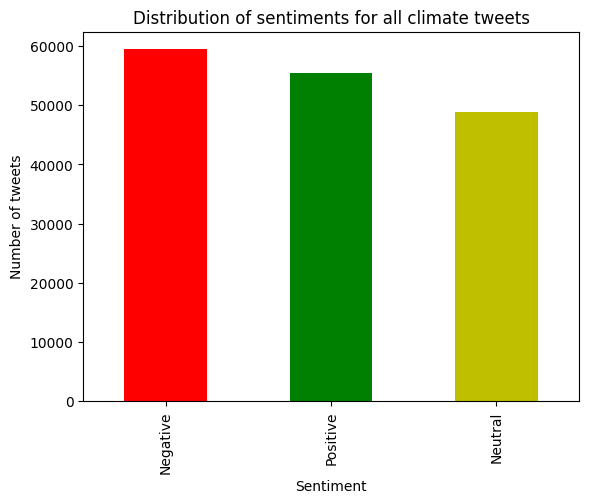

In [31]:
# Show the distribution of sentiments for all climate tweet data
twitter_climate_data.sentiment_label.value_counts().plot(kind='bar', color=['r', 'g', 'y'])
plt.xlabel('Sentiment')
plt.ylabel('Number of tweets')
plt.title('Distribution of sentiments for all climate tweets')
plt.xticks([0, 1, 2], ['Negative', 'Positive', 'Neutral'])

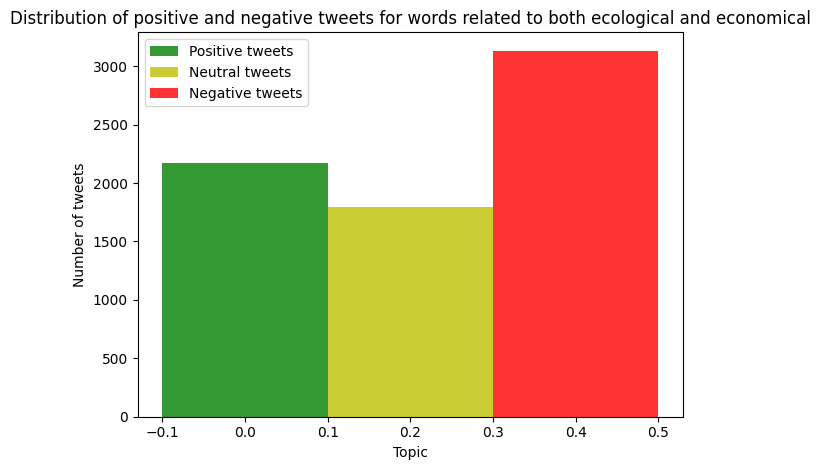

In [32]:
# Data to plot
n_groups = 1
positive = (2171) # (number of positive Ecological tweets, number of positive Economical tweets)
negative = (3133) # (number of negative Ecological tweets, number of negative Economical tweets)
neutral = (1798)

# Create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

bar1 = plt.bar(index, positive, bar_width, alpha=opacity, color='g', label='Positive tweets')
bar2 = plt.bar(index + bar_width, neutral, bar_width, alpha=opacity, color='y', label='Neutral tweets')
bar3 = plt.bar(index + bar_width*2, negative, bar_width, alpha=opacity, color='r', label='Negative tweets')

plt.xlabel('Topic')
plt.ylabel('Number of tweets')
plt.title('Distribution of positive and negative tweets for words related to both ecological and economical')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
def determine_sentiment(df):

    # Relevant words in the tweets that identify to certain ecological or economical topic
    ecological_words = '.*co2.*|.*carbon.*|.*emissions.*|.*emission.*|.*disaster.*|.*weather.*|.*flood.*|.*storm.*|.*water.*|drought.*|.*sea.*|.*energy.*|.*arctic.*|.*heat.*|.*heat wave.*|.*climate change.*|.*climate action.*|.*coal.*|.*environment.*|.*fossil.*|.*wildfire.*|.*ice.*|.*hot.*|.*solar.*|.*pollution.*|.*cold.*|.*temperature.*|.*greenhouse.*|.*afforestation.*|.*ocean.*|.*forest.*|.*extinction.*|.*species.*|.*scientist.*|.*agriculture.*|.*manufacture.*|.*renewable.*'
    economical_words = '.*gdp.*|.*policy.*|.*job.*|.*law.*|.*trump.*|.*president.*|.*cop.*|.*government.*|.*tax.*|.*work.*|.*public.*|.*administration.*|.*bill.*|.*money.*|.*economy.*|.*movement.*|.*debate.*|.*capitalism.*|.*fighting.*|.*humanity.*|.*political.*|.*minister.*|.*conference.*|.*politics.*|.*economic.*'
    # Create three new columns: ecological, economical, and Others
    df['Ecological'] = ''
    df['Economical'] = ''
    df['Others'] = ''

    for i in df.index:
        if re.match (ecological_words, df['cleaned_tweet'][i]) :
            if df['sentiment_label'][i] == '1': # if the sentiment is positive, add 'positive'
                df["Ecological"][i] = 'positive'
            elif df['sentiment_label'][i] == '0': # if the sentiment is neutral
                df["Ecological"][i] = 'neutral'
            else :
                df["Ecological"][i] = 'negative' # if the sentiment is negative, add 'negative'

        if re.match (economical_words, df['cleaned_tweet'][i]) :
            if df['sentiment_label'][i] == '1': # if the sentiment is positive, add 'positive'
                df["Economical"][i] = 'positive'
            elif df['sentiment_label'][i] == '0': # if the sentiment is neutral
                df["Economical"][i] = 'neutral'
            else :
                df["Economical"][i] = 'negative' # if the sentiment is negative, add 'negative'

        if df["Ecological"][i] == '' and df["Economical"][i] == '':
            if df['sentiment_label'][i] == '1': # if the sentiment is positive, add 'positive'
                df["Others"][i] = 'positive'
            elif df['sentiment_label'][i] == '0': # if the sentiment is neutral
                df["Others"][i] = 'neutral'
            else :
                df["Others"][i] = 'negative' # if the sentiment is negative, add 'negative'

In [34]:
# Apply this function to the twitter dataset.
determine_sentiment(twitter_climate_data)

<ipython-input-33-f31842ecdfaf>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Others"][i] = 'positive'
<ipython-input-33-f31842ecdfaf>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Ecological"][i] = 'positive'
<ipython-input-33-f31842ecdfaf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Ecological"][i] = 'neutral'
<ipython-input-33-f31842ecdfaf>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [35]:
# Separate the dataset into positive and negative for each parties. These variables will also be used later in the analysis
ecological_positive = twitter_climate_data[twitter_climate_data.Ecological == 'positive']
economical_positive = twitter_climate_data[twitter_climate_data.Economical == 'positive']
ecological_negative = twitter_climate_data[twitter_climate_data.Ecological == 'negative']
economical_negative = twitter_climate_data[twitter_climate_data.Economical == 'negative']
ecological_neutral = twitter_climate_data[twitter_climate_data.Ecological == 'neutral']
economical_neutral = twitter_climate_data[twitter_climate_data.Economical == 'neutral']

# Print the number of positive and negative sentiments of each party.
print("Positive sentiments about the ecological effects of climate change: ", ecological_positive.Ecological.count())
print("Negative sentiment about the ecological effects of climate change: ", ecological_negative.Ecological.count())
print("Neutral sentiment about the ecological effects of climate change: ", ecological_neutral.Economical.count())
print("Positive sentiment about the economical effects of climate change: ", economical_positive.Economical.count())
print("Negative sentiment about the economical effects of climate change: ", economical_negative.Economical.count())
print("Neutral sentiment about the economical effects of climate change: ", economical_neutral.Economical.count())

Positive sentiments about the ecological effects of climate change:  31064
Negative sentiment about the ecological effects of climate change:  38372
Neutral sentiment about the ecological effects of climate change:  26523
Positive sentiment about the economical effects of climate change:  12389
Negative sentiment about the economical effects of climate change:  15388
Neutral sentiment about the economical effects of climate change:  12526


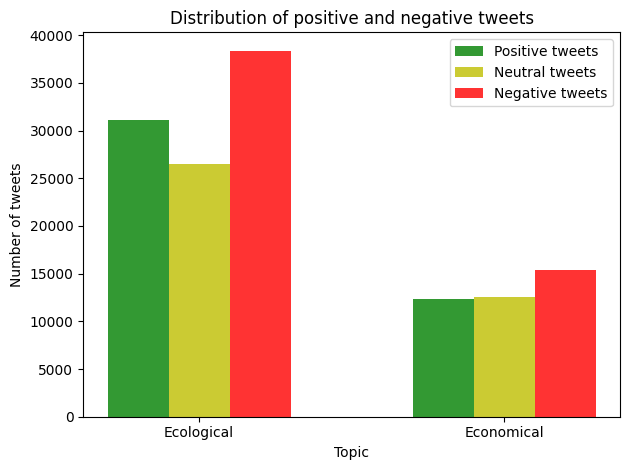

In [36]:
# Data to plot
n_groups = 2
positive = (31064, 12389) # (number of positive Ecological tweets, number of positive Economical tweets)
negative = (38372, 15388) # (number of negative Ecological tweets, number of negative Economical tweets)
neutral = (26523,12526) # (number of neutral Ecological tweets, number of neutral Economical tweets)

# Create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

bar1 = plt.bar(index, positive, bar_width, alpha=opacity, color='g', label='Positive tweets')
bar2 = plt.bar(index + bar_width, neutral, bar_width, alpha=opacity, color='y', label='Neutral tweets')
bar3 = plt.bar(index + bar_width*2, negative, bar_width, alpha=opacity, color='r', label='Negative tweets')


plt.xlabel('Topic')
plt.ylabel('Number of tweets')
plt.title('Distribution of positive and negative tweets')
plt.xticks(index + bar_width, ('Ecological', 'Economical'))
plt.legend()

plt.tight_layout()
plt.show()

From this visual we see that we have almost double the amount of Negative sentiment tweets than Neutral and Positive tweets, for both the Ecological and Economical category for 2017-2019. It can be assumed that both the Ecological and Economical aspects of climate change have a negative sentiment affiliated with it, and rightfully so! Climate change needs action!

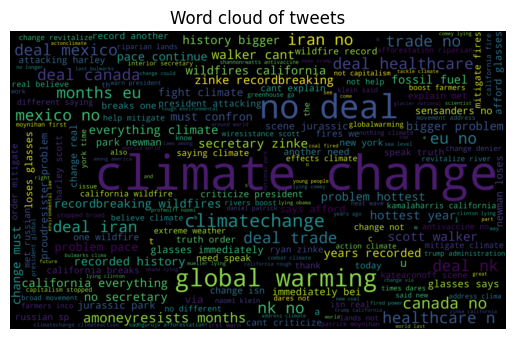

In [37]:
# combine all the tweets into one string
combined_sent = ''
for tweet in twitter_climate_data['cleaned_tweet']:
    combined_sent = combined_sent + '' + tweet

# Generate the word cloud
cloud_sent = WordCloud(width=5000, height=3000, stopwords={'ht', 'htt', 'http', 'https', 'httpst'}).generate(combined_sent)

# Display the word cloud
plt.imshow(cloud_sent, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of tweets')
plt.show()

In this exploratory section, we also want to see what sorts of words are used most frequently in the public's tweets. Climate change and global warming will obviously be the most common. There are also other relevant words such as fossil fuel, wildfires, change, healthcare, deals (probably regarding policy changes), and names of various important political figures.

# Model preparation

We apply Bag of Words (BOW) and term frequency–inverse document frequency (TF-IDF) to the general topic twitter dataset, and run various machine learning models to compare the accuracy of sentiment prediction. We select the model with the highest accuracy and apply the model to the climate change dataset, in order to predict the sentiment of climate change related data.

### Create Bag of Words features

In [43]:
# Create Bag of Words.
vect_bow = CountVectorizer(max_features=3000, ngram_range=(1, 3), stop_words= ['ht', 'htt', 'http', 'https', 'httpst'])
vect_bow.fit(twitter_df.clean_text)
X_bow = vect_bow.transform(twitter_df.clean_text)

# Transform back to a dataframe, assign column names
X_bow = pd.DataFrame(X_bow.toarray(), columns=vect_bow.get_feature_names_out())

# Display first 5 rows of the dataframe
X_bow.head()

,100,1000,130,1st,200,2000,2002,2004,2012,2013,...,your own,your party,youre,yours,yourself,youth,youtube,yrs,zero,शबच
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# convert to sparse matrix
X_bow = csr_matrix(X_bow)

In [46]:
# Train test split and prepare the data for multiple classification algorithms for BOW
y_b = twitter_df.category
X_b = X_bow

# Train/test split
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.3, random_state=42)

### Create TF-IDF Features

In [ ]:
# Create TF-IDF
vect_tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 3), stop_words=['ht', 'htt', 'http', 'https', 'httpst'])
vect_tfidf.fit(twitter_df.clean_text)
X_tfidf = vect_tfidf.transform(twitter_df.clean_text)

# Create a DataFrame
X_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=vect_tfidf.get_feature_names_out())

# Display first 5 rows of the dataframe
X_tfidf.head()

In [52]:
# convert to sparse matrix
X_tfidf = csr_matrix(X_tfidf)

In [53]:
# Split the tweets randomly into 70% training and 30% test data for TF-IDF.
y_t = twitter_df.category
X_t = X_tfidf

# Train/test split
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_t, y_t, test_size=0.3, random_state=42)

### Preparing data for multiple classification algorithms and comparing their accuracy scores

#### Accuracy values for BOW

In [54]:
# Logistic Regression accuracy
model = LogisticRegression(max_iter=1000000).fit(X_train_b, y_train_b)
y_predicted = model.predict(X_test_b)
accuracy = accuracy_score(y_test_b, y_predicted)
print('Accuracy of ' + LogisticRegression().__class__.__name__, ': ', accuracy)

Accuracy of LogisticRegression :  0.8887525311407007


In [1]:
# KNN accuracy
model = KNeighborsClassifier().fit(X_train_b, y_train_b)
y_predicted = model.predict(X_test_b)
accuracy = accuracy_score(y_test_b, y_predicted)
print('Accuracy of ' + KNeighborsClassifier().__class__.__name__, ': ', accuracy)

NameError: ignored

In [ ]:
# Naive Bayes accuracy
# Note: dense data is required since sparce matrix gave me an error. Used X.toarray() to convert to a dense numpy array.
model = GaussianNB().fit(X_train_b.toarray(), y_train_b)
y_predicted = model.predict(X_test_b.toarray())
accuracy = accuracy_score(y_test_b, y_predicted)
print('Accuracy of ' + GaussianNB().__class__.__name__, ': ', accuracy)

In [ ]:
# SVM accuracy
model = LinearSVC(max_iter=1000000).fit(X_train_b, y_train_b)
y_predicted = model.predict(X_test_b)
accuracy = accuracy_score(y_test_b, y_predicted)
print('Accuracy of ' + LinearSVC().__class__.__name__, ': ', accuracy)

In [ ]:
# Decision tree accuracy
model = DecisionTreeClassifier().fit(X_train_b, y_train_b)
y_predicted = model.predict(X_test_b)
accuracy = accuracy_score(y_test_b, y_predicted)
print('Accuracy of ' + DecisionTreeClassifier().__class__.__name__, ': ', accuracy)

In [ ]:
# Random Forest accuracy
model = RandomForestClassifier().fit(X_train_b, y_train_b)
y_predicted = model.predict(X_test_b)
accuracy = accuracy_score(y_test_b, y_predicted)
print('Accuracy of ' + RandomForestClassifier().__class__.__name__, ': ', accuracy)

#### Accuracy values for TF-IDF

In [ ]:
model = LogisticRegression(max_iter=1000000).fit(X_train_t, y_train_t)
y_predicted = model.predict(X_test_t)
accuracy = accuracy_score(y_test_t, y_predicted)
print('Accuracy of ' + LogisticRegression().__class__.__name__, ': ', accuracy)

In [ ]:
model = KNeighborsClassifier().fit(X_train_t, y_train_t)
y_predicted = model.predict(X_test_t)
accuracy = accuracy_score(y_test_t, y_predicted)
print('Accuracy of ' + KNeighborsClassifier().__class__.__name__, ': ', accuracy)

In [ ]:
# A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.
model = GaussianNB().fit(X_train_t.toarray(), y_train_t)
y_predicted = model.predict(X_test_t.toarray())
accuracy = accuracy_score(y_test_t, y_predicted)
print('Accuracy of ' + GaussianNB().__class__.__name__, ': ', accuracy)

In [ ]:
model = LinearSVC(max_iter=1000000).fit(X_train_t, y_train_t)
y_predicted = model.predict(X_test_t)
accuracy = accuracy_score(y_test_t, y_predicted)
print('Accuracy of ' + LinearSVC().__class__.__name__, ': ', accuracy)

In [ ]:
model = DecisionTreeClassifier().fit(X_train_t, y_train_t)
y_predicted = model.predict(X_test_t)
accuracy = accuracy_score(y_test_t, y_predicted)
print('Accuracy of ' + DecisionTreeClassifier().__class__.__name__, ': ', accuracy)

In [ ]:
model = RandomForestClassifier().fit(X_train_t, y_train_t)
y_predicted = model.predict(X_test_t)
accuracy = accuracy_score(y_test_t, y_predicted)
print('Accuracy of ' + RandomForestClassifier().__class__.__name__, ': ', accuracy)

### Model implementation

Select the model with the highest accuracy (89.3% for SVC using BOW) to predict the tweets on climate change.

In [ ]:
# Create BOW features for the twitter_climate_data
vect = CountVectorizer(max_features=3000, ngram_range=(1, 3))  # set max features to be 3000 and uni- to tri-grams
vect.fit(twitter_climate_data.cleaned_tweet)
X = vect.transform(twitter_climate_data.cleaned_tweet)

# Transform back to a dataframe, assign column names
X = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())

# convert to sparse matrix
X = csr_matrix(X)

# Define the target variable (y_twitter) and the predictor variables (X_twitter).
y_twitter = twitter_climate_data.sentiment_label
X_twitter = X

# Train using the best model
model = LogisticRegression(max_iter=1000000).fit(X_train_b, y_train_b)

# Predict the labels
y_predicted = model.predict(X_twitter)

# Print accuracy score on the elections data
print('Accuracy on the Social Media Climate Sentiment Data: ', accuracy_score(y_twitter, y_predicted))

# Evaluate model's predictions
print(metrics.classification_report(y_twitter, y_predicted))

Accuracy on the Social Media Climate Sentiment Data:  0.3581130207919643
              precision    recall  f1-score   support

          -1       0.46      0.23      0.31     59434
           0       0.34      0.63      0.44     48824
           1       0.32      0.26      0.29     55411

    accuracy                           0.36    163669
   macro avg       0.37      0.37      0.35    163669
weighted avg       0.38      0.36      0.34    163669



Text(0.5, 1.0, 'Confusion Matrix on the Social Media Climate Sentiment Data')

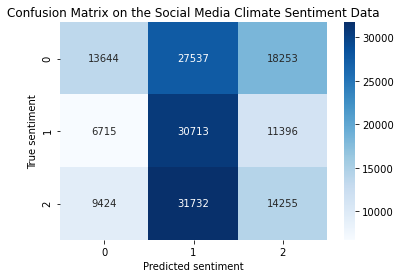

In [ ]:
# Display the confusion matrix
cm = confusion_matrix(y_twitter, y_predicted)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted sentiment')
ax.set_ylabel('True sentiment')
ax.set_title('Confusion Matrix on the Social Media Climate Sentiment Data')

## Predict the popularity of the sentiment on the climate change tweets

Field "retweet_count" can be used to indicate the popularity of the sentiment and is "hot topic"

In [ ]:
twitter_climate_data.retweet_count.describe()

count    163669.000000
mean       2779.584967
std       11986.976965
min           0.000000
25%           1.000000
50%          17.000000
75%         392.000000
max      169247.000000
Name: retweet_count, dtype: float64

Divided popularity measure into 3 categories based on min, max, and interquartile range:
- retweeted 0 to 17 times --> not popular
- retweeted 18 to 392 times --> popular
- retweeted 393 to 169247 times --> very popular

In [ ]:
# add a new column popularity next to the retweet_count
category = pd.cut(twitter_climate_data.retweet_count, bins=[-1,17,392,169247],
                  labels=['not popular', 'popular', 'very popular'])
twitter_climate_data.insert(5, 'popularity', category)

In [ ]:
twitter_climate_data

,cleaned_tweet,cleaned_tweet_tokenized,sentiment,sentiment_label,created_at_date,popularity,retweet_count,relevant_words,Others,Ecological,Economical
0,gotta love facts,"[got, ta, love, facts]",0.6369,1,8/13/2018,not popular,0,,positive,,
1,toolangiforest great day action message “ dear...,"[toolangiforest, great, day, action, message, ...",0.8805,1,8/13/2018,popular,35,,,positive,
2,jonkudelka harvey norman reckons climate chang...,"[jonkudelka, harvey, norman, reckons, climate,...",0.0000,0,8/13/2018,not popular,0,neutral,,neutral,
3,jayrosennyu skepticism immigration walk hand h...,"[jayrosennyu, skepticism, immigration, walk, h...",0.5267,1,8/13/2018,popular,52,,,positive,
4,franceinireland th november call creative citi...,"[franceinireland, th, november, call, creative...",0.4939,1,8/13/2018,not popular,16,,positive,,
...,...,...,...,...,...,...,...,...,...,...,...
163664,rrn epa cancels talk climate change agency sci...,"[rrn, epa, cancels, talk, climate, change, age...",-0.2263,-1,10/23/2017,not popular,0,,,negative,
163665,time epa pulled scientists climate change conf...,"[time, epa, pulled, scientists, climate, chang...",0.0000,0,10/23/2017,popular,78,,,neutral,neutral
163666,cathmckenna must take action climatechange,"[cathmckenna, must, take, action, climatechange]",0.0000,0,10/23/2017,popular,21,,neutral,,
163667,time epa pulled scientists climate change conf...,"[time, epa, pulled, scientists, climate, chang...",0.0000,0,10/23/2017,popular,125,,,neutral,neutral


In [ ]:
# Number of samples in each category
twitter_climate_data.popularity.value_counts()

not popular     82039
very popular    40915
popular         40715
Name: popularity, dtype: int64

# Model preparation

### Create Bag of Words features

In [38]:
# Create Bag of Words.
vect_bow = CountVectorizer(max_features=3000, ngram_range=(1, 3), stop_words=['ht', 'htt', 'http', 'https', 'httpst'])
vect_bow.fit(twitter_climate_data.cleaned_tweet)
X_bow = vect_bow.transform(twitter_climate_data.cleaned_tweet)

# Transform back to a dataframe, assign column names
X_bow = pd.DataFrame(X_bow.toarray(), columns=vect_bow.get_feature_names_out())

# Display first 5 rows of the dataframe
X_bow.head()

,abbott,abc,ability,able,abortion,absolutely,ac,accept,access,according,...,zinke insists,zinke insists california,zinke recordbreaking,zinke recordbreaking wildfires,zinke says,zinke says climate,งจ,ตว,อง,แต
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# convert to sparse matrix
X_bow = csr_matrix(X_bow)

In [42]:
# Train test split and prepare the data for multiple classification algorithms for BOW
y_b = twitter_climate_data.popularity
X_b = X_bow

# Train/test split
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.3, random_state=42)

AttributeError: ignored

### Create TF-IDF Features

In [ ]:
# Create TF-IDF
vect_tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 3), stop_words=['ht', 'htt', 'http', 'https', 'httpst'])
vect_tfidf.fit(twitter_climate_data.cleaned_tweet)
X_tfidf = vect_tfidf.transform(twitter_climate_data.cleaned_tweet)

# Create a DataFrame
X_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=vect_tfidf.get_feature_names_out())

# Display first 5 rows of the dataframe
X_tfidf.head()

In [ ]:
# convert to sparse matrix
X_tfidf = csr_matrix(X_tfidf)

In [ ]:
# Split the tweets randomly into 70% training and 30% test data for TF-IDF.
y_t = twitter_climate_data.popularity
X_t = X_tfidf

# Train/test split
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_t, y_t, test_size=0.3, random_state=42)

### Run multiple classification algorithms and comparing their accuracy scores

#### Accuracy values for BOW

In [ ]:
# Logistic Regression accuracy
model = LogisticRegression(max_iter=1000000).fit(X_train_b, y_train_b)
y_predicted = model.predict(X_test_b)
accuracy = accuracy_score(y_test_b, y_predicted)
print('Accuracy of ' + LogisticRegression().__class__.__name__, ': ', accuracy)

In [ ]:
# KNN accuracy
model = KNeighborsClassifier().fit(X_train_b, y_train_b)
y_predicted = model.predict(X_test_b)
accuracy = accuracy_score(y_test_b, y_predicted)
print('Accuracy of ' + KNeighborsClassifier().__class__.__name__, ': ', accuracy)

In [ ]:
# Naive Bayes accuracy
# Note: dense data is required since sparce matrix gave me an error. Used X.toarray() to convert to a dense numpy array.
model = GaussianNB().fit(X_train_b.toarray(), y_train_b)
y_predicted = model.predict(X_test_b.toarray())
accuracy = accuracy_score(y_test_b, y_predicted)
print('Accuracy of ' + GaussianNB().__class__.__name__, ': ', accuracy)

In [ ]:
# SVM accuracy
model = LinearSVC(max_iter=1000000).fit(X_train_b, y_train_b)
y_predicted = model.predict(X_test_b)
accuracy = accuracy_score(y_test_b, y_predicted)
print('Accuracy of ' + LinearSVC().__class__.__name__, ': ', accuracy)

In [ ]:
# Decision tree accuracy
model = DecisionTreeClassifier().fit(X_train_b, y_train_b)
y_predicted = model.predict(X_test_b)
accuracy = accuracy_score(y_test_b, y_predicted)
print('Accuracy of ' + DecisionTreeClassifier().__class__.__name__, ': ', accuracy)

In [ ]:
# Random Forest accuracy
model = RandomForestClassifier().fit(X_train_b, y_train_b)
y_predicted = model.predict(X_test_b)
accuracy = accuracy_score(y_test_b, y_predicted)
print('Accuracy of ' + RandomForestClassifier().__class__.__name__, ': ', accuracy)

#### Accuracy values for TF-IDF

In [ ]:
model = LogisticRegression(max_iter=1000000).fit(X_train_t, y_train_t)
y_predicted = model.predict(X_test_t)
accuracy = accuracy_score(y_test_t, y_predicted)
print('Accuracy of ' + LogisticRegression().__class__.__name__, ': ', accuracy)

In [ ]:
model = KNeighborsClassifier().fit(X_train_t, y_train_t)
y_predicted = model.predict(X_test_t)
accuracy = accuracy_score(y_test_t, y_predicted)
print('Accuracy of ' + KNeighborsClassifier().__class__.__name__, ': ', accuracy)

In [ ]:
# A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.
model = GaussianNB().fit(X_train_t.toarray(), y_train_t)
y_predicted = model.predict(X_test_t.toarray())
accuracy = accuracy_score(y_test_t, y_predicted)
print('Accuracy of ' + GaussianNB().__class__.__name__, ': ', accuracy)

In [ ]:
model = LinearSVC(max_iter=1000000).fit(X_train_t, y_train_t)
y_predicted = model.predict(X_test_t)
accuracy = accuracy_score(y_test_t, y_predicted)
print('Accuracy of ' + LinearSVC().__class__.__name__, ': ', accuracy)

In [ ]:
model = DecisionTreeClassifier().fit(X_train_t, y_train_t)
y_predicted = model.predict(X_test_t)
accuracy = accuracy_score(y_test_t, y_predicted)
print('Accuracy of ' + DecisionTreeClassifier().__class__.__name__, ': ', accuracy)

In [ ]:
model = RandomForestClassifier().fit(X_train_t, y_train_t)
y_predicted = model.predict(X_test_t)
accuracy = accuracy_score(y_test_t, y_predicted)
print('Accuracy of ' + RandomForestClassifier().__class__.__name__, ': ', accuracy)

### Select the best performing model: Random Forest classifier with 88% accuracy

In [ ]:
# Print accuracy score
print('Accuracy on the Popularity of Sentiment of Climate Change: ', accuracy_score(y_test_t, y_predicted))

# Evaluate model's predictions
print(metrics.classification_report(y_test_t, y_predicted))

In [ ]:
# Display the confusion matrix
cm = confusion_matrix(y_test_t, y_predicted)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted popularity')
ax.set_ylabel('True popularity')
ax.set_title('Confusion Matrix on the Popularity of Sentiment of Climate Change')

0 --> not popular <br>
1 --> popular <br>
2 --> very popular

### Determining clusters of words to determine topics

In [ ]:
pip install gensim

In [ ]:
pip install pyLDAvis

In [ ]:
pip install pyLDAvis.gensim

In [ ]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction
import numpy as np
import json
import glob

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from nltk.corpus import stopwords

#vis
import pyLDAvis
#import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

![image.png](attachment:image.png)
source: https://medium.com/@osas.usen/topic-extraction-from-tweets-using-lda-a997e4eb0985

In [ ]:
data_words = twitter_data.cleaned_tweet_tokenized.tolist()

In [ ]:
id2word = corpora.Dictionary(data_words)

corpus = []
for text in data_words:
    new = id2word.doc2bow(text)
    corpus.append(new)

print (corpus[0][0:20])

word = id2word[[0][:1][0]]
print (word)

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

#### Visualizing the data

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis